<a href="https://colab.research.google.com/github/EnisSah/fastai_imdb_classification.ipynb/blob/master/11_fastai_imdb_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from fastai.basics import *
from fastai.gen_doc.nbdoc import *

In [3]:
import fastai
from fastai.version import __version__
print(__version__)

1.0.61


## Text

Next application is text, so let's start by importing everything we'll need.

In [4]:
from fastai.text import *

### Language modelling

First we'll fine-tune a pretrained language model on our subset of imdb.

In [5]:
imdb = untar_data(URLs.IMDB_SAMPLE)

In [6]:
data_lm = (TextList.from_csv(imdb, 'texts.csv', cols='text')
                   .split_by_rand_pct()
                   .label_for_lm()  # Language model does not need labels
                   .databunch())
data_lm.save()

`data.show_batch()` will work here as well. For a language model, it shows us the beginning of each sequence of text along the batch dimension (the target being to guess the next word).

In [7]:
data_lm.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


idx,text
0,"! ! ! xxmaj finally this was directed by the guy who did xxmaj big xxmaj xxunk ? xxmaj must be a xxunk of xxmaj jonestown - hollywood style . xxmaj xxunk ! xxbos xxmaj this is a extremely well - made film . xxmaj the acting , script and camera - work are all first - rate . xxmaj the music is good , too , though it is"
1,very disappointed at this xxmaj spike xxmaj lee effort ! ! xxbos a really great movie and true story . xxmaj dan xxmaj jansen the xxmaj greatest xxunk ever . a touching and beautiful movie the whole family can enjoy . xxmaj the story of xxmaj jane xxmaj xxunk battle with cancer and xxmaj dan xxmaj jansen love for his sister . xxmaj of a important promise made by xxmaj
2,"jokes , people getting xxunk , and the skit about the xxmaj president all make the movie one of the worst of all time . \n \n xxmaj it 's a really bad film that you have to stay away from . xxmaj all the "" jokes "" are so juvenile that you will find yourself laughing because they are so stupid . xxmaj the plot is so bad"
3,"just like stepping into a comic book . xxmaj this is the movie i think of when the xxmaj mob is mentioned , the suits , the xxunk and the xxunk . \n \n xxmaj hoffman gives comic relief as xxmaj xxunk and you ca n't help but feel sorry for xxmaj xxunk as she tries , and fails , to win xxmaj tracy over . xxmaj this movie"
4,"xxunk to xxmaj valjean and xxmaj cosette , he says the one line in the movie that set me screaming at the xxup tv set . "" xxmaj we are n't xxunk . "" i could hear xxmaj victor xxmaj hugo xxunk in his grave . xxup of xxup course xxup they xxup are xxup xxunk ! xxmaj they want to revolt against the pseudo - xxunk that is in"


In [8]:
# Special tokens
# xxbos: Begining of a sentence
# xxfld: Represent separate parts of a document like title, summary etc., each one will get a separate field and so they will get numbered (e.g. xxfld 1, xxfld 2).
# xxup: If there's something in all caps, it gets lower cased and a token called xxup will get added to it. Words that are fully capitalized, such as “I AM SHOUTING”, are tokenized as “xxup i xxup am xxup shouting“
# xxunk: token used instead of an uncommon word.
# xxmaj: token indicates that there is capitalization of the word. “The” will be tokenized as “xxmaj the“.
# xxrep: token indicates repeated word, if you have 29 ! in a row, (i.e. xxrep 29 !).

In [9]:
data_lm.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 ',',
 '.',
 'and',
 'a',
 'of',
 'to',
 'is',
 'it',
 'in',
 'i']

#### Numericalization
Finally it is easier for machine to deal with the numbers so replace the tokens with the location of the token in the vocab:

In [10]:
data_lm.train_ds[0][0].data[:10]

array([  2,   5,   0,  24,   0,  24, 935,  54,   5,   0])

The default vocab size is set to 60,000 words and min count for a word to be added to vocab is 2, to avoid getting the weight matrix huge.

Now let's define a language model learner. drop_mult - a hyper-parameter ,used for regularization, sets the amount of dropout. If the model is over-fitting increase it, if under-fitting, you can decrease the number.

In [11]:
learn = language_model_learner(data_lm, AWD_LSTM)
learn.fit_one_cycle(4, 1e-2)
learn.save('mini_train_lm')
learn.save_encoder('mini_train_encoder')

epoch,train_loss,valid_loss,accuracy,time
0,4.388712,3.761825,0.294628,00:09
1,4.139682,3.719764,0.297500,00:09
2,3.926246,3.712339,0.296935,00:09
3,3.765955,3.706908,0.297262,00:09


Then we can have a look at the results. It shows a certain amount of words (default 20), then the next 20 target words and the ones that were predicted.

In [12]:
learn.show_results()

text,target,pred
"xxbos i had heard good things about this film and was , you guessed it , a bit disappointed .","xxmaj xxunk xxmaj xxunk is as promised surprisingly good , surprisingly confident , at a young age ; really all","xxmaj it was xxunk , a good as well as but well , and the very age , xxmaj ,"
especially offensive - the one in which xxmaj xxunk xxunk his tongue after being xxunk by another man ( could,"it really have been that gross ) , and the scene where xxmaj eastwood is xxunk by xxmaj xxunk 's",have be be been a he out . but xxmaj xxunk was xxmaj al xxunk xxunk by xxmaj al 's
"xxmaj willie was not ready to xxunk ( and has been forcing his nephew and agent , xxmaj ben (",xxmaj richard xxmaj xxunk ) to try to get him jobs in commercials . xxmaj but xxmaj willie ca n't,xxmaj xxunk xxmaj xxunk ) to xxunk to make his to ) the ) xxmaj but xxmaj xxunk xxmaj n't
was stuck in somewhat of a career xxunk by the time this one came along . xxmaj as with so,"many early xxunk stars , it seemed that his time had come and gone , that he was fine for","many other xxmaj , , it was like the xxunk was been to he . and he was a ,"
"not completely insane , do n't see it . xxmaj please . xxbos xxmaj that xxmaj certain xxmaj thing is",the story of a gold xxunk ( xxmaj xxunk xxmaj dana ) from a xxunk house . xxmaj her mother,"a best of a xxmaj xxunk , xxmaj xxunk ) xxunk ) , xxmaj xxmaj xxunk . xxmaj the xxunk"


In [13]:
learn.predict('When I saw this movie the second time', 100)


'When I saw this movie the second time i had seen it , i again sat on it . This is what makes me loved this movie . The old fashioned - of - acting calm and fresh live time ! The suspend of existence lets me out of control , certainly of course in cinema , as i was not very bad . This motion picture did not pay much however , i tense , seen nothing better , but it wanted to be shot amongst those very bad and realistic look . xxbos This is the best - known of these'

In [14]:
learn.predict('As I was going up the stair I met a man who wasn\'t there.', 100)

"As I was going up the stair I met a man who wasn't there. a single drunk at some point in the 80 's was a half - dozen if he were not in any way so high a man tried to sit through the graveyard or settle in half the woods . The plot was mediocre a movie as a drag main horribly miraculously file for me is thinks it does n't even exist . Some of the things are hungarian stuff topics are cheap . , every entry has a great plot . Although the first few show around about Everybody Lies is the problem that"

Learning rate hyper-parameter is one of the most important parameters to train a model. Fast.ai provides a convenient utility (learn.lr_find) to search through a range of learning rates to find the optimum one for our dataset. Learning rate finder will increase the learning rate after each mini-batch. Eventually, the learning rate is too high that loss will get worse. Now look at the plot of learning rate against loss and determine the lowest point (around 1e-1 for the plot below) and go back by one magnitude and choose that as a learning rate (something around 1e-2).

### Classification

Now let's see a classification example. We have to use the same vocabulary as for the language model if we want to be able to use the encoder we saved.

In [15]:
data_clas = (TextList.from_csv(imdb, 'texts.csv', cols='text', vocab=data_lm.vocab)
                   .split_from_df(col='is_valid')
                   .label_from_df(cols='label')
                   .databunch(bs=42))

Here show_batch shows the beginning of each review with its target.

In [16]:
data_clas.show_batch()

text,target
"xxbos xxmaj xxunk xxmaj victor xxmaj xxunk : a xxmaj review \n \n xxmaj you know , xxmaj xxunk xxmaj victor xxmaj xxunk is like sticking your hands into a big , xxunk xxunk of xxunk . xxmaj it 's warm and xxunk , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and xxunk xxmaj xxunk xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj xxunk ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj xxunk to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj xxunk for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the xxunk - up xxunk of xxmaj new xxmaj xxunk . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj xxunk",positive
"xxbos xxmaj many xxunk that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . xxmaj with graphics",positive


And we can train a classifier that uses our previous encoder.

In [17]:
learn_cl = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_cl.load_encoder('mini_train_encoder')
learn_cl.fit_one_cycle(6, slice(1e-3,1e-2))
learn_cl.save('mini_train_clas')

epoch,train_loss,valid_loss,accuracy,time
0,0.645639,0.631381,0.660000,00:07
1,0.554392,0.736741,0.605000,00:07
2,0.510266,0.485453,0.745000,00:08
3,0.470510,0.429310,0.790000,00:08
4,0.447449,0.484786,0.750000,00:08
5,0.426175,0.505177,0.740000,00:08


**Momentum**  
There is one more argument(moms=(0.8,0.7))﹣momentums equals 0.8,0.7. Basically for training recurrent neural networks (RNNs), it really helps to decrease the momentum a little bit.The right side above is the momentum plot. Every time our learning rate is small, our momentum is high. Why is that? Because as you are learning small learning rate, but you keep going in the same direction, you may as well go faster (higher momentum). But as you are learning high learning rate, but you keep going in the same direction, you may overshoot the target, so momentum should be slowed. This trick can help you train 10 times faster.

In [18]:
learn_cl.fit_one_cycle(2, slice(1e-3,1e-2), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.380399,0.572213,0.740000,00:07
1,0.379248,0.561646,0.735000,00:08


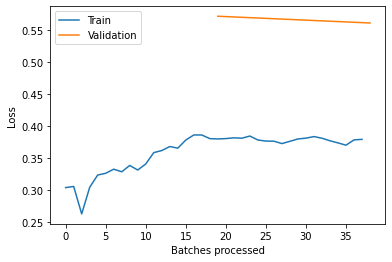

In [19]:
learn_cl.recorder.plot_losses()

In [20]:
learn_cl.show_results()

text,target,prediction
"xxbos \n \n i 'm sure things did n't exactly go the same way in the real life of xxmaj homer xxmaj hickam as they did in the film adaptation of his book , xxmaj rocket xxmaj boys , but the movie "" xxmaj october xxmaj sky "" ( an xxunk of the book 's title ) is good enough to stand alone . i have not read xxmaj",positive,positive
"xxbos xxmaj to review this movie , i without any doubt would have to quote that memorable scene in xxmaj tarantino 's "" xxmaj pulp xxmaj fiction "" ( xxunk ) when xxmaj jules and xxmaj vincent are talking about xxmaj mia xxmaj wallace and what she does for a living . xxmaj jules tells xxmaj vincent that the "" xxmaj only thing she did worthwhile was pilot "" .",negative,negative
"xxbos xxmaj how viewers react to this new "" adaption "" of xxmaj shirley xxmaj jackson 's book , which was promoted as xxup not being a remake of the original 1963 movie ( true enough ) , will be based , i suspect , on the following : those who were big fans of either the book or original movie are not going to think much of this one",negative,negative
"xxbos xxmaj the trouble with the book , "" xxmaj memoirs of a xxmaj geisha "" is that it had xxmaj japanese xxunk but underneath the xxunk it was all an xxmaj american man 's way of thinking . xxmaj reading the book is like watching a magnificent ballet with great music , sets , and costumes yet performed by xxunk animals dressed in those xxunk far from xxmaj japanese",negative,negative
"xxbos xxmaj bonanza had a great cast of wonderful actors . xxmaj xxunk xxmaj xxunk , xxmaj pernell xxmaj whitaker , xxmaj michael xxmaj xxunk , xxmaj dan xxmaj blocker , and even xxmaj guy xxmaj williams ( as the cousin who was brought in for several episodes during 1964 to replace xxmaj adam when he was leaving the series ) . xxmaj the cast had chemistry , and they",positive,positive


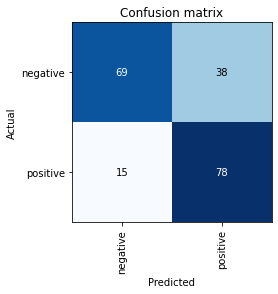

In [21]:
preds, y, losses = learn_cl.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn_cl, preds, y, losses)
interp.plot_confusion_matrix()

### Excercise
Make sentiment predictions for 5 movie reviews from IMDB web site.

In [22]:
first_movie_review = learn.predict('This endlessly fascinating swirl ', 58)
first_movie_review

'This endlessly fascinating swirl  may have been done obviously from a look at Lindsay Marie De Resources during the early nineties . The Cher music is realm of believable statements about the Australian Army , the capacity for typically dramatic war . Russian audiences have plenty of Bette Davis ,'

In [23]:
real_first_movie_review = print('This endlessly fascinating swirl of a film could have come only from Nolan, who blends the cerebral twistiness of Memento (his thriller that moves backward in time) with the spectacular action of his Batman megahit, The Dark Knight')

This endlessly fascinating swirl of a film could have come only from Nolan, who blends the cerebral twistiness of Memento (his thriller that moves backward in time) with the spectacular action of his Batman megahit, The Dark Knight


In [24]:
second_movie_quote= learn.predict('The greatest trick the Devil ever pulled', 14)
second_movie_quote

'The greatest trick the Devil ever pulled out of the hands of an unknown man is the construction of a mine'

In [25]:
real_second_quote = print("The greatest trick the Devil ever pulled was convincing the world he didn't exist")

The greatest trick the Devil ever pulled was convincing the world he didn't exist


In [26]:
third_movie_review = learn.predict('Overall, the film is one of a kind,',35)
third_movie_review

'Overall, the film is one of a kind, the most wrenching " took is what seems to be better . " The time between This Night Rises and Grim Rain is n\'t quite acceptable , and the'

In [27]:
real_third_movie_review = print('Overall, the film is one of a kind, a masterpiece and a work of art so to speak. The superior musical score that accompanies the film heightens the suspense and adds to the mystery sequences.')

Overall, the film is one of a kind, a masterpiece and a work of art so to speak. The superior musical score that accompanies the film heightens the suspense and adds to the mystery sequences.


In [28]:
fourth_movie_review = learn.predict('Nolan masterfully weaves', 28)
fourth_movie_review

"Nolan masterfully weaves learn of his childhood , Cain 's father 's killing father ( from played by the father of the late 20th century , giants and fairy -"

In [29]:
real_fourth_review = print('Nolan masterfully weaves all these elements together, creating a second act that is breathtaking, suspenseful and thought-provoking...unfortunately, it takes us a good hour for us to get there.')

Nolan masterfully weaves all these elements together, creating a second act that is breathtaking, suspenseful and thought-provoking...unfortunately, it takes us a good hour for us to get there.


In [30]:
fifth_movie_review = learn.predict('Infused with',27)
fifth_movie_review

"Infused with language day are virtually impossible , because the beach is did n't have any examples . Means person to want to be deaf is totally confined"

In [31]:
real_fifth_movie_review = print('Infused with his trademark wit, the film is hilarious at times but also carries with it more complex undertones. Benjamin is a gorgeous little film.')

Infused with his trademark wit, the film is hilarious at times but also carries with it more complex undertones. Benjamin is a gorgeous little film.


In [32]:
fifth_movie_review_classifier = learn_cl.predict(fifth_movie_review)
print(fifth_movie_review_classifier[2])

tensor([0.9737, 0.0263])
